# Unravelling the complex interplay between environmental drivers and conflict

This notebook contains a already relatively mature pipeline to assess the accuracy of different scale- and modelalgorithms.

**Note:** This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

In its current form, we first make a selection of conflicts to be used for training and testing the model. Selection criteria are amongst others minimum number of fatalities and climate zones. Subsequently, annual statistics (now: mean) of a range of environmental variables are determined per geographic unit (now: water provinces) and stored along with a 0/1 conflict value. The number of variables to be sampled is flexible and can be easily adapted in the cfg-file. 

This dataset is subsequently scaled, split, and applied in a machine learning model. Since there are various ways out there to scale your data and then fit and predict, the notebook is designed such that a variable amount of scalers and models can be specified. All possible combinations of scaler and model are then evaluated and output saved to an output directory.

All model settings need to be defined in the run_settings.cfg file.

For questions, please contact J.M. Hoch (j.m.hoch@uu.nl).

With contributions from N. Wanders (Utrecht University) and S. de Bruin (PBL).

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, neighbors, naive_bayes, preprocessing, model_selection, metrics, utils
import os, sys
import warnings

In [2]:
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [3]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.3b4
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

Based on this settings-file, the set-up of the run can be initialized.

In [5]:
config, out_dir = conflict_model.utils.initiate_setup(settings_file)

saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT


# Filter conflicts

Not all conflicts of the database should be used for the model. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is very likely that the conflict is not water-related.

First, get the subset of conflicts based on user-defined conditions in the settings file. To filter out non-water-related conflicts, we use only those conflicts falling in climate zones notoriously known for water shortages.

In [6]:
conflict_gdf, extent_gdf, extent_active_polys_gdf, global_df = conflict_model.selection.select(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged201.csv

translating to geopandas dataframe

filtering on conflict properties...
...filtering key best with lower value 1
...filtering key type_of_violence with value(s) ['1', '2', '3']
focussing on period between 2000 and 2015
reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp

fixing invalid geometries

clipping clipping conflict dataset to extent



Have a brief glimpse at the spatial distribution of the selected conflicts. As background map, we use all water provinces to give it a nicer visual expression.

Depending on the settings, we may focus on some climate zones only. As such, not all water provinces are used in the model. For a visual inspection if this selection worked as intended, we plot below the conflicts and as background map only those water provinces that are actually used in the model.

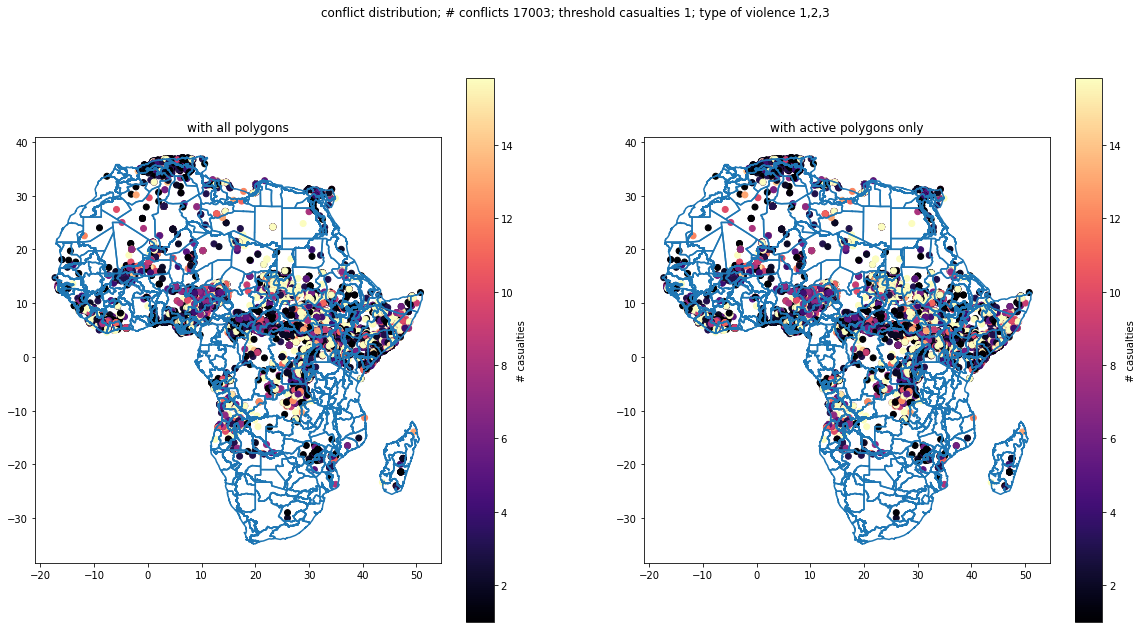

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('conflict distribution; # conflicts {}; threshold casualties {}; type of violence {}'.format(len(conflict_gdf), config.get('conflict', 'min_nr_casualties'), config.get('conflict', 'type_of_violence')))

conflict_gdf.plot(ax=ax1, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_gdf.boundary.plot(ax=ax1)
ax1.set_title('with all polygons')

conflict_gdf.plot(ax=ax2, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_active_polys_gdf.boundary.plot(ax=ax2)
ax2.set_title('with active polygons only')
                         
plt.savefig(os.path.join(out_dir, 'conflict_and_casualties_distribution.png'), dpi=300)

# Analysis per year

This is an essential part of the code. Here, we go through all model years as specified in the settings-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit or not;
2. Loop through various files with environmental variables and get mean variable value per geographical unit.

This is all stored in a dictionary for easy processing. We first need to initialize this dictionary containing a pandas Series per provided environmental variable. To keep this automated, each 'key' in the section 'env_var' in the cfg-file should be equal to the variable name used on the corresponding nc-file. Then, add a pandas Series for the conflict data.

In [8]:
# %%capture

X, Y = conflict_model.pipeline.create_XY(config, conflict_gdf, extent_active_polys_gdf)

loading XY data from file C:\Users\hoch0001\Documents\_code\conflict_model\data\XY.npy

number of data points including missing values: 5790
number of data points excluding missing values: 5760
from this, 1216 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 21.11 percent.


# Machine Learning

## Data preparation

Before we can get started, we have to prepare the sampled data such that it is compatible with the Machine Learning (ML) models.

We see that only a very small amout of conflicts are sampled. This small fraction compared to the vast amoutn of non-conflicts indicates we have an **imbalanced problem** and thus will need to account for this in the settings of the model used and data pre-processing.

## ML modelling pipeline

This pipeline allows to combine various scalers and models to find the best-performing combination and assess sensitivities.

### Data pre-processing

Before we can train and predict with the model, we need to scale the variable data. This is required because our input data has a range of units (or not) and values vary in orders of magnitude. 

Besides, it is important to create separate training- and testdata for both variables and target.

#### Scaler

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

The scaler is then used to fit the data and transform it according to scaler-specific method. I don't scale Y since it is either 0 or 1 already.

The scaled variable data X_scaled is, together with the target data Y, split into trainings and test data. The fraction of the total data that is used for training is user-defined.

The scatterplot of the first two variables in X_train looks like this. Also the sample size n_train is provided used to train the data alongside with the total variable sample size n_tot.

### Models

The variety of ML models is sheer endless. We here use two models for supervised learning which showed better performance than other candidates in previous assessment rounds. Also, all model parameters were already calibrated using GridSearchCV in previous analyses.

In [9]:
scaler, clf = conflict_model.pipeline.prepare_ML(config)

chosen scaling method is [QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)]
chosen ML model is [KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')]


### The model pipeline

The model pipeline starts with **splitting the data in scaled train and test samples**. 

It then contains a number of steps which are performed for each scaler-model combination, explained hereafter.

#### ***k-fold cross-validation***

It is important to check how robust the models are in terms of accuracy as well as under- and overfitting. To that end, we apply **cross-validation (CV)** to fit the training-data against each other by splitting it up in chunks (as defined by k) and one chunk against all other k-1 chunks. k is 10 in our case, the default value is 5.

#### ***Model fitting and prediction***

Subsequently, we fit the models based on the training-data. With a fitted model, we can predict our target based on the remaining test-data.


All these steps are placed into functions and are step-wise called from a master function:

In [10]:
out_X_df = conflict_model.evaluation.init_out_df()
out_X1_df = conflict_model.evaluation.init_out_df()
out_y_df = conflict_model.evaluation.init_out_df()
out_y1_df = conflict_model.evaluation.init_out_df()

In [11]:
out_dict = conflict_model.evaluation.init_out_dict()

In [12]:
trps, aucs, mean_fpr = conflict_model.evaluation.init_out_ROC_curve()

In [13]:
trps1, aucs1, mean_fpr1 = conflict_model.evaluation.init_out_ROC_curve()

run 1 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.872
Precision: 0.769
Recall: 0.585
F1 score: 0.665
Brier loss score: 0.096
Cohen-Kappa score: 0.587
ROC AUC score 0.900

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1353
           1       0.77      0.59      0.66       376

    accuracy                           0.87      1729
   macro avg       0.83      0.77      0.79      1729
weighted avg       0.87      0.87      0.86      1729




No handles with labels found to put in legend.


run 2 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.865


No handles with labels found to put in legend.


Precision: 0.727
Recall: 0.620
F1 score: 0.669
Brier loss score: 0.098
Cohen-Kappa score: 0.585
ROC AUC score 0.895

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1347
           1       0.73      0.62      0.67       382

    accuracy                           0.86      1729
   macro avg       0.81      0.78      0.79      1729
weighted avg       0.86      0.86      0.86      1729


run 3 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.876
Precision: 0.799
Recall: 0.602
F1 score: 0.686
Brier loss score: 0.092
Cohen-Kappa score: 0.611
ROC AUC score 0.903

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1340
           1       0.80      0.60      0.69       389

    accuracy                           0.88      1729
   macro avg       0.85      0.78      0.80      1729
weighted avg       0.87      0.88     

No handles with labels found to put in legend.


run 4 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data



No handles with labels found to put in legend.


Accuracy: 0.872
Precision: 0.751
Recall: 0.561
F1 score: 0.642
Brier loss score: 0.090
Cohen-Kappa score: 0.566
ROC AUC score 0.910

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1374
           1       0.75      0.56      0.64       355

    accuracy                           0.87      1729
   macro avg       0.82      0.76      0.78      1729
weighted avg       0.86      0.87      0.86      1729


run 5 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.869


No handles with labels found to put in legend.


Precision: 0.744
Recall: 0.596
F1 score: 0.662
Brier loss score: 0.091
Cohen-Kappa score: 0.582
ROC AUC score 0.911

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1358
           1       0.74      0.60      0.66       371

    accuracy                           0.87      1729
   macro avg       0.82      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729


run 6 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.867


No handles with labels found to put in legend.


Precision: 0.751
Recall: 0.607
F1 score: 0.671
Brier loss score: 0.095
Cohen-Kappa score: 0.589
ROC AUC score 0.903

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1342
           1       0.75      0.61      0.67       387

    accuracy                           0.87      1729
   macro avg       0.82      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729


run 7 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.862
Precision: 0.729
Recall: 0.568
F1 score: 0.638
Brier loss score: 0.097
Cohen-Kappa score: 0.555
ROC AUC score 0.897

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1359
           1       0.73      0.57      0.64       370

    accuracy                           0.86      1729
   macro avg       0.81      0.76      0.78      1729
weighted avg       0.85      0.86     

No handles with labels found to put in legend.


run 8 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.861


No handles with labels found to put in legend.


Precision: 0.742
Recall: 0.552
F1 score: 0.633
Brier loss score: 0.095
Cohen-Kappa score: 0.550
ROC AUC score 0.904

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1354
           1       0.74      0.55      0.63       375

    accuracy                           0.86      1729
   macro avg       0.81      0.75      0.77      1729
weighted avg       0.85      0.86      0.85      1729


run 9 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.865


No handles with labels found to put in legend.


Precision: 0.744
Recall: 0.575
F1 score: 0.649
Brier loss score: 0.097
Cohen-Kappa score: 0.567
ROC AUC score 0.900

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1355
           1       0.74      0.57      0.65       374

    accuracy                           0.87      1729
   macro avg       0.82      0.76      0.78      1729
weighted avg       0.86      0.87      0.86      1729


run 10 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.866


No handles with labels found to put in legend.


Precision: 0.705
Recall: 0.624
F1 score: 0.662
Brier loss score: 0.095
Cohen-Kappa score: 0.579
ROC AUC score 0.903

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1365
           1       0.70      0.62      0.66       364

    accuracy                           0.87      1729
   macro avg       0.80      0.78      0.79      1729
weighted avg       0.86      0.87      0.86      1729


run 11 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.860


No handles with labels found to put in legend.


Precision: 0.748
Recall: 0.552
F1 score: 0.636
Brier loss score: 0.098
Cohen-Kappa score: 0.551
ROC AUC score 0.897

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1347
           1       0.75      0.55      0.64       382

    accuracy                           0.86      1729
   macro avg       0.82      0.75      0.77      1729
weighted avg       0.85      0.86      0.85      1729


run 12 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data



No handles with labels found to put in legend.


Accuracy: 0.868
Precision: 0.758
Recall: 0.606
F1 score: 0.673
Brier loss score: 0.097
Cohen-Kappa score: 0.592
ROC AUC score 0.905

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1341
           1       0.76      0.61      0.67       388

    accuracy                           0.87      1729
   macro avg       0.83      0.77      0.80      1729
weighted avg       0.86      0.87      0.86      1729


run 13 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.875


No handles with labels found to put in legend.


Precision: 0.727
Recall: 0.646
F1 score: 0.684
Brier loss score: 0.088
Cohen-Kappa score: 0.607
ROC AUC score 0.914

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1367
           1       0.73      0.65      0.68       362

    accuracy                           0.88      1729
   macro avg       0.82      0.79      0.80      1729
weighted avg       0.87      0.88      0.87      1729


run 14 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.870
Precision: 0.717
Recall: 0.598
F1 score: 0.652
Brier loss score: 0.094
Cohen-Kappa score: 0.573
ROC AUC score 0.894

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1378
           1       0.72      0.60      0.65       351

    accuracy                           0.87      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.86      0.87    

No handles with labels found to put in legend.


run 15 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.863
Precision: 0.719
Recall: 0.589
F1 score: 0.648
Brier loss score: 0.095
Cohen-Kappa score: 0.564
ROC AUC score 0.901

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1359
           1       0.72      0.59      0.65       370

    accuracy                           0.86      1729
   macro avg       0.81      0.76      0.78      1729
weighted avg       0.86      0.86      0.86      1729




No handles with labels found to put in legend.


run 16 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data



No handles with labels found to put in legend.


Accuracy: 0.857
Precision: 0.693
Recall: 0.634
F1 score: 0.662
Brier loss score: 0.101
Cohen-Kappa score: 0.572
ROC AUC score 0.886

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1347
           1       0.69      0.63      0.66       382

    accuracy                           0.86      1729
   macro avg       0.80      0.78      0.79      1729
weighted avg       0.85      0.86      0.85      1729


run 17 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data



No handles with labels found to put in legend.


Accuracy: 0.876
Precision: 0.788
Recall: 0.581
F1 score: 0.669
Brier loss score: 0.088
Cohen-Kappa score: 0.595
ROC AUC score 0.922

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1357
           1       0.79      0.58      0.67       372

    accuracy                           0.88      1729
   macro avg       0.84      0.77      0.80      1729
weighted avg       0.87      0.88      0.87      1729


run 18 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.870
Precision: 0.754
Recall: 0.619
F1 score: 0.680
Brier loss score: 0.092
Cohen-Kappa score: 0.599
ROC AUC score 0.910

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1343
           1       0.75      0.62      0.68       386

    accuracy                           0.87      1729
   macro avg       0.82      0.78      0.80      1729
weighted avg       0.

No handles with labels found to put in legend.


run 19 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.874
Precision: 0.734
Recall: 0.631
F1 score: 0.679
Brier loss score: 0.089
Cohen-Kappa score: 0.601
ROC AUC score 0.914

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1366
           1       0.73      0.63      0.68       363

    accuracy                           0.87      1729
   macro avg       0.82      0.79      0.80      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 20 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.871
Precision: 0.686
Recall: 0.619
F1 score: 0.651
Brier loss score: 0.092
Cohen-Kappa score: 0.572
ROC AUC score 0.897

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1393
           1       0.69      0.62      0.65       336

    accuracy                           0.87      1729
   macro avg       0.80      0.78      0.79      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 21 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.872
Precision: 0.726
Recall: 0.601
F1 score: 0.657
Brier loss score: 0.086
Cohen-Kappa score: 0.580
ROC AUC score 0.918

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1376
           1       0.73      0.60      0.66       353

    accuracy                           0.87      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 22 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.867
Precision: 0.732
Recall: 0.592
F1 score: 0.655
Brier loss score: 0.093
Cohen-Kappa score: 0.573
ROC AUC score 0.905

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1361
           1       0.73      0.59      0.65       368

    accuracy                           0.87      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 23 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.858
Precision: 0.722
Recall: 0.591
F1 score: 0.650
Brier loss score: 0.098
Cohen-Kappa score: 0.561
ROC AUC score 0.902

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1343
           1       0.72      0.59      0.65       386

    accuracy                           0.86      1729
   macro avg       0.80      0.76      0.78      1729
weighted avg       0.85      0.86      0.85      1729




No handles with labels found to put in legend.


run 24 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.864
Precision: 0.752
Recall: 0.596
F1 score: 0.665
Brier loss score: 0.095
Cohen-Kappa score: 0.581
ROC AUC score 0.902

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1338
           1       0.75      0.60      0.66       391

    accuracy                           0.86      1729
   macro avg       0.82      0.77      0.79      1729
weighted avg       0.86      0.86      0.86      1729




No handles with labels found to put in legend.


run 25 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.723
Recall: 0.580
F1 score: 0.644
Brier loss score: 0.097
Cohen-Kappa score: 0.555
ROC AUC score 0.904

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1343
           1       0.72      0.58      0.64       386

    accuracy                           0.86      1729
   macro avg       0.80      0.76      0.78      1729
weighted avg       0.85      0.86      0.85      1729




No handles with labels found to put in legend.


run 26 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.873
Precision: 0.735
Recall: 0.642
F1 score: 0.685
Brier loss score: 0.092
Cohen-Kappa score: 0.606
ROC AUC score 0.909

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1358
           1       0.73      0.64      0.68       371

    accuracy                           0.87      1729
   macro avg       0.82      0.79      0.80      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 27 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data



No handles with labels found to put in legend.


Accuracy: 0.872
Precision: 0.708
Recall: 0.637
F1 score: 0.671
Brier loss score: 0.093
Cohen-Kappa score: 0.592
ROC AUC score 0.901

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1376
           1       0.71      0.64      0.67       353

    accuracy                           0.87      1729
   macro avg       0.81      0.78      0.80      1729
weighted avg       0.87      0.87      0.87      1729


run 28 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.862
Precision: 0.730
Recall: 0.578
F1 score: 0.645
Brier loss score: 0.099
Cohen-Kappa score: 0.561
ROC AUC score 0.891

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1355
           1       0.73      0.58      0.64       374

    accuracy                           0.86      1729
   macro avg       0.81      0.76      0.78      1729
weighted avg       0.

No handles with labels found to put in legend.


run 29 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.861
Precision: 0.729
Recall: 0.559
F1 score: 0.633
Brier loss score: 0.096
Cohen-Kappa score: 0.549
ROC AUC score 0.897

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1359
           1       0.73      0.56      0.63       370

    accuracy                           0.86      1729
   macro avg       0.81      0.75      0.77      1729
weighted avg       0.85      0.86      0.85      1729




No handles with labels found to put in legend.


run 30 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.854
Precision: 0.687
Recall: 0.564
F1 score: 0.620
Brier loss score: 0.100
Cohen-Kappa score: 0.530
ROC AUC score 0.891

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1364
           1       0.69      0.56      0.62       365

    accuracy                           0.85      1729
   macro avg       0.79      0.75      0.76      1729
weighted avg       0.85      0.85      0.85      1729




No handles with labels found to put in legend.


run 31 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.882
Precision: 0.765
Recall: 0.630
F1 score: 0.691
Brier loss score: 0.088
Cohen-Kappa score: 0.619
ROC AUC score 0.917

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1367
           1       0.77      0.63      0.69       362

    accuracy                           0.88      1729
   macro avg       0.84      0.79      0.81      1729
weighted avg       0.88      0.88      0.88      1729




No handles with labels found to put in legend.


run 32 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.857
Precision: 0.682
Recall: 0.567
F1 score: 0.620
Brier loss score: 0.098
Cohen-Kappa score: 0.532
ROC AUC score 0.890

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1373
           1       0.68      0.57      0.62       356

    accuracy                           0.86      1729
   macro avg       0.79      0.75      0.77      1729
weighted avg       0.85      0.86      0.85      1729




No handles with labels found to put in legend.


run 33 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.869
Precision: 0.739
Recall: 0.599
F1 score: 0.662
Brier loss score: 0.094
Cohen-Kappa score: 0.582
ROC AUC score 0.902

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1360
           1       0.74      0.60      0.66       369

    accuracy                           0.87      1729
   macro avg       0.82      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 34 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.877
Precision: 0.717
Recall: 0.629
F1 score: 0.670
Brier loss score: 0.088
Cohen-Kappa score: 0.595
ROC AUC score 0.905

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1387
           1       0.72      0.63      0.67       342

    accuracy                           0.88      1729
   macro avg       0.81      0.78      0.80      1729
weighted avg       0.87      0.88      0.87      1729




No handles with labels found to put in legend.


run 35 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.868
Precision: 0.726
Recall: 0.610
F1 score: 0.663
Brier loss score: 0.095
Cohen-Kappa score: 0.581
ROC AUC score 0.899

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1360
           1       0.73      0.61      0.66       369

    accuracy                           0.87      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 36 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.872
Precision: 0.720
Recall: 0.626
F1 score: 0.670
Brier loss score: 0.088
Cohen-Kappa score: 0.591
ROC AUC score 0.912

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1371
           1       0.72      0.63      0.67       358

    accuracy                           0.87      1729
   macro avg       0.81      0.78      0.80      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 37 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.859
Precision: 0.708
Recall: 0.591
F1 score: 0.644
Brier loss score: 0.100
Cohen-Kappa score: 0.557
ROC AUC score 0.890

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1355
           1       0.71      0.59      0.64       374

    accuracy                           0.86      1729
   macro avg       0.80      0.76      0.78      1729
weighted avg       0.85      0.86      0.85      1729




No handles with labels found to put in legend.


run 38 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.867
Precision: 0.711
Recall: 0.586
F1 score: 0.643
Brier loss score: 0.091
Cohen-Kappa score: 0.562
ROC AUC score 0.911

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1376
           1       0.71      0.59      0.64       353

    accuracy                           0.87      1729
   macro avg       0.80      0.76      0.78      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 39 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.876
Precision: 0.751
Recall: 0.603
F1 score: 0.669
Brier loss score: 0.091
Cohen-Kappa score: 0.593
ROC AUC score 0.906

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1369
           1       0.75      0.60      0.67       360

    accuracy                           0.88      1729
   macro avg       0.83      0.78      0.80      1729
weighted avg       0.87      0.88      0.87      1729




No handles with labels found to put in legend.


run 40 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.876
Precision: 0.780
Recall: 0.585
F1 score: 0.669
Brier loss score: 0.088
Cohen-Kappa score: 0.595
ROC AUC score 0.919

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1360
           1       0.78      0.59      0.67       369

    accuracy                           0.88      1729
   macro avg       0.84      0.77      0.80      1729
weighted avg       0.87      0.88      0.87      1729




No handles with labels found to put in legend.


run 41 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.874
Precision: 0.715
Recall: 0.613
F1 score: 0.660
Brier loss score: 0.085
Cohen-Kappa score: 0.584
ROC AUC score 0.920

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1385
           1       0.72      0.61      0.66       344

    accuracy                           0.87      1729
   macro avg       0.81      0.78      0.79      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 42 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.864
Precision: 0.733
Recall: 0.603
F1 score: 0.662
Brier loss score: 0.094
Cohen-Kappa score: 0.577
ROC AUC score 0.908

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1346
           1       0.73      0.60      0.66       383

    accuracy                           0.86      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.86      0.86      0.86      1729




No handles with labels found to put in legend.


run 43 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.869
Precision: 0.753
Recall: 0.586
F1 score: 0.659
Brier loss score: 0.092
Cohen-Kappa score: 0.579
ROC AUC score 0.906

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1355
           1       0.75      0.59      0.66       374

    accuracy                           0.87      1729
   macro avg       0.82      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 44 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.868
Precision: 0.776
Recall: 0.569
F1 score: 0.657
Brier loss score: 0.095
Cohen-Kappa score: 0.577
ROC AUC score 0.902

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1346
           1       0.78      0.57      0.66       383

    accuracy                           0.87      1729
   macro avg       0.83      0.76      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


run 45 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.877
Precision: 0.742
Recall: 0.605
F1 score: 0.667
Brier loss score: 0.089
Cohen-Kappa score: 0.592
ROC AUC score 0.912

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1377
           1       0.74      0.61      0.67       352

    accuracy                           0.88      1729
   macro avg       0.82      0.78      0.80      1729
weighted avg       0.87      0.88      0.87      1729




No handles with labels found to put in legend.


run 46 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.876
Precision: 0.722
Recall: 0.625
F1 score: 0.670
Brier loss score: 0.089
Cohen-Kappa score: 0.594
ROC AUC score 0.910

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1380
           1       0.72      0.62      0.67       349

    accuracy                           0.88      1729
   macro avg       0.82      0.78      0.80      1729
weighted avg       0.87      0.88      0.87      1729




No handles with labels found to put in legend.


run 47 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.851
Precision: 0.726
Recall: 0.575
F1 score: 0.642
Brier loss score: 0.103
Cohen-Kappa score: 0.549
ROC AUC score 0.891

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1327
           1       0.73      0.57      0.64       402

    accuracy                           0.85      1729
   macro avg       0.80      0.75      0.77      1729
weighted avg       0.84      0.85      0.84      1729




No handles with labels found to put in legend.


run 48 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.889
Precision: 0.785
Recall: 0.641
F1 score: 0.706
Brier loss score: 0.084
Cohen-Kappa score: 0.638
ROC AUC score 0.921

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1370
           1       0.78      0.64      0.71       359

    accuracy                           0.89      1729
   macro avg       0.85      0.80      0.82      1729
weighted avg       0.88      0.89      0.88      1729




No handles with labels found to put in legend.


run 49 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.874
Precision: 0.719
Recall: 0.621
F1 score: 0.667
Brier loss score: 0.092
Cohen-Kappa score: 0.589
ROC AUC score 0.903

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1378
           1       0.72      0.62      0.67       351

    accuracy                           0.87      1729
   macro avg       0.81      0.78      0.79      1729
weighted avg       0.87      0.87      0.87      1729




No handles with labels found to put in legend.


run 50 of 50

### USING ALL DATA ###

fitting and transforming X

splitting both X and Y in train and test data

Accuracy: 0.866
Precision: 0.723
Recall: 0.612
F1 score: 0.663
Brier loss score: 0.094
Cohen-Kappa score: 0.580
ROC AUC score 0.905

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1358
           1       0.72      0.61      0.66       371

    accuracy                           0.87      1729
   macro avg       0.81      0.77      0.79      1729
weighted avg       0.86      0.87      0.86      1729




No handles with labels found to put in legend.


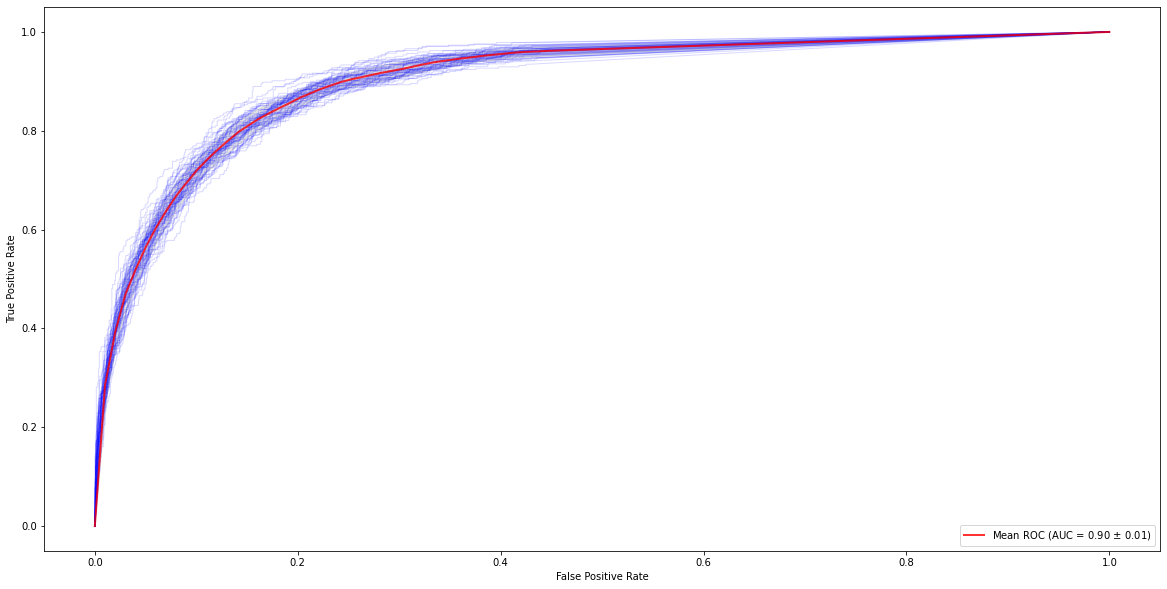

In [14]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

for n in range(config.getint('settings', 'n_runs')):
    
    if config.getboolean('general', 'verbose'):
        print('run {} of {}'.format(n+1, config.getint('settings', 'n_runs')) + os.linesep)

    X_df, y_df, eval_dict = conflict_model.pipeline.run(X, Y, config, scaler, clf, out_dir)
    
    X1_df, y1_df = conflict_model.utils.get_conflict_datapoints_only(X_df, y_df)
    
    out_X_df = conflict_model.evaluation.fill_out_df(out_X_df, X_df)
    out_X1_df = conflict_model.evaluation.fill_out_df(out_X1_df, X1_df)
    out_y_df = conflict_model.evaluation.fill_out_df(out_y_df, y_df)
    out_y1_df = conflict_model.evaluation.fill_out_df(out_y1_df, y1_df)
    
    out_dict = conflict_model.evaluation.fill_out_dict(out_dict, eval_dict)

    tprs, aucs = conflict_model.evaluation.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

conflict_model.evaluation.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

plt.savefig(os.path.join(out_dir, 'ROC_curve_per_run.png'), dpi=300)

#### ***Evaluation***

We have now produced a set of predictions, y_pred. This can be comapred with the retained test-targets y_test to evaluate the prediction. There are many ways to do this and several are applied here.

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The main classification metrics are nicely summarized in the **classification report**:

**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Another nice way to vizualize the accuracy of our results is the **confusion matrix**. The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

Yet another metric is the **Brier score** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier score is relatively sensitive for imbalanced datasets (https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/).

The **ROC score** (Receiver Operating Characteristic, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) is relatively insensitive for an imbalanced dataset. The ROC curve is a plot of the true positive rate versus the false positive rate for the predictions of a model for multiple thresholds between 0.0 and 1.0. A ROC-AUC value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas an ROC-AUC of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. An ROC-AUC of 0.0 suggests perfectly incorrect predictions.

Last but not least, the **F1 score**, also known as balanced F-score or F-measure. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1%20score#sklearn.metrics.f1_score)

In [15]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config.getint('settings', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 50 repetitions is 0.868
average Precision of run with 50 repetitions is 0.734
average Recall of run with 50 repetitions is 0.600
average F1 score of run with 50 repetitions is 0.660
average Cohen-Kappa score of run with 50 repetitions is 0.579
average Brier loss score of run with 50 repetitions is 0.093
average ROC AUC score of run with 50 repetitions is 0.904


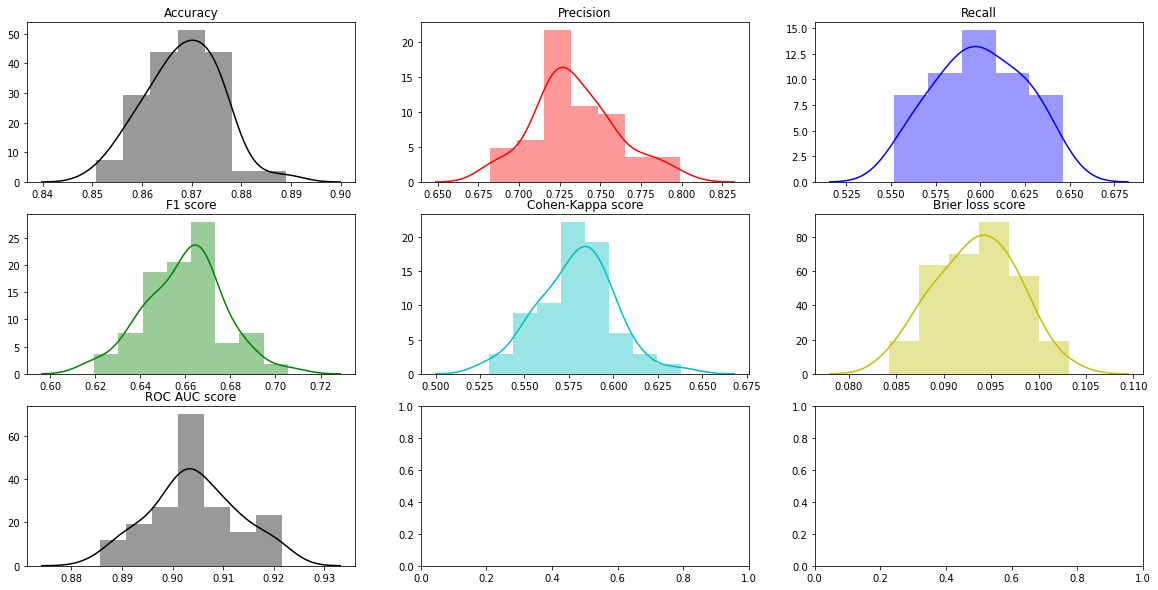

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
sbs.distplot(out_dict['Accuracy'], ax=axes[0,0], color="k")
axes[0,0].set_title('Accuracy')
sbs.distplot(out_dict['Precision'], ax=axes[0,1], color="r")
axes[0,1].set_title('Precision')
sbs.distplot(out_dict['Recall'], ax=axes[0,2], color="b")
axes[0,2].set_title('Recall')
sbs.distplot(out_dict['F1 score'], ax=axes[1,0], color="g")
axes[1,0].set_title('F1 score')
sbs.distplot(out_dict['Cohen-Kappa score'], ax=axes[1,1], color="c")
axes[1,1].set_title('Cohen-Kappa score')
sbs.distplot(out_dict['Brier loss score'], ax=axes[1,2], color="y")
axes[1,2].set_title('Brier loss score')
sbs.distplot(out_dict['ROC AUC score'], ax=axes[2,0], color="k")
axes[2,0].set_title('ROC AUC score')
plt.savefig(os.path.join(out_dir, 'distribution_output_evaluation_criteria.png'), dpi=300)

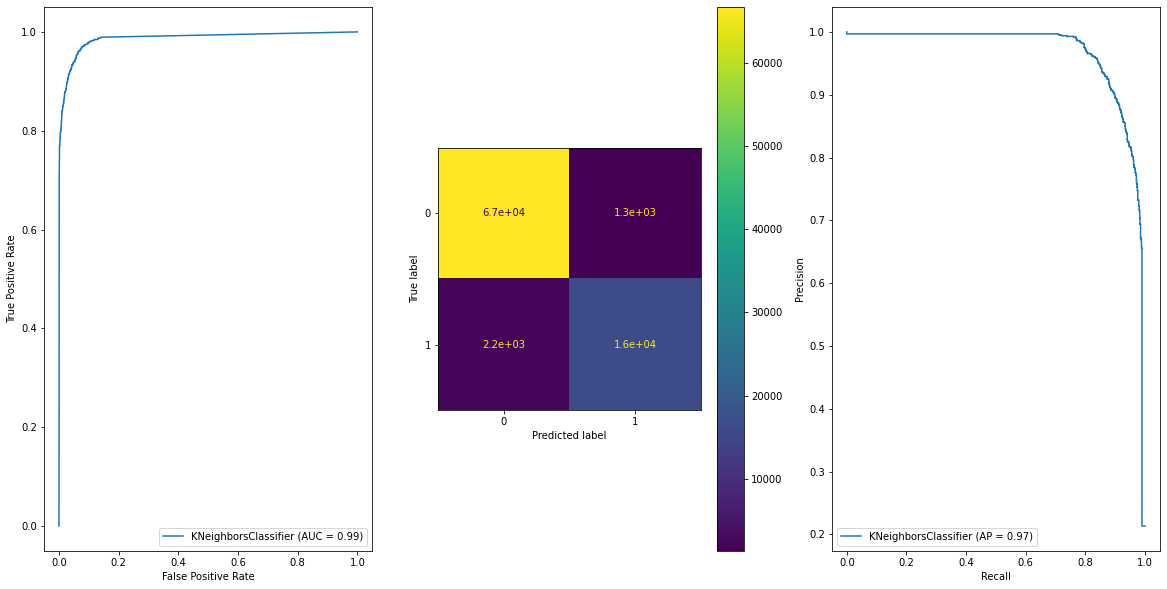

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
metrics.plot_roc_curve(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax1)
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax2)
metrics.plot_precision_recall_curve(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax3)
plt.savefig(os.path.join(out_dir, 'evaluation_plots_all_data.png'), dpi=300)

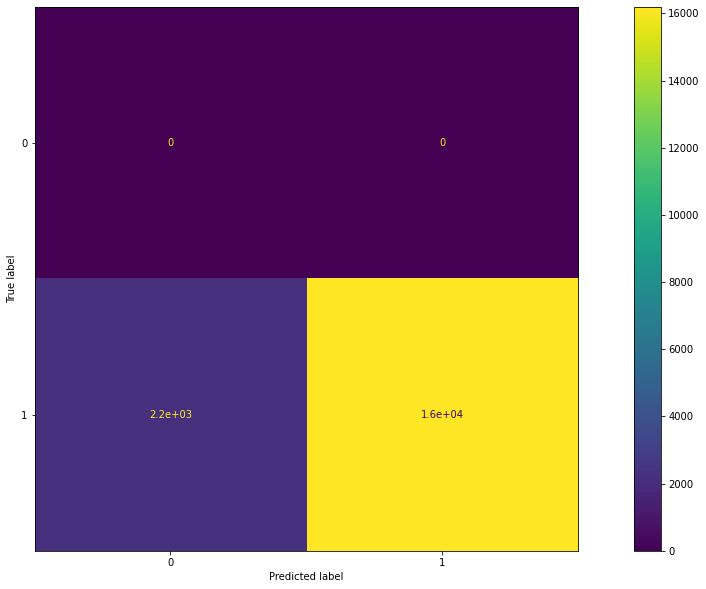

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
metrics.plot_confusion_matrix(clf, out_X1_df.to_numpy(), out_y1_df.y_test.to_list(), ax=ax1)
plt.savefig(os.path.join(out_dir, 'confusion_matrix_conflict_data.png'), dpi=300)

All other print-statements and plots in the output folder!

In [19]:
df_hit, gdf_hit = conflict_model.evaluation.get_average_hit(out_y_df, global_df)

In [20]:
df_hit_1, gdf_hit_1 = conflict_model.evaluation.get_average_hit(out_y1_df, global_df)

In [21]:
print('the fraction of data points with predicted conflict in all data points is {0:0.2f}'.format(len(out_y1_df)/len(out_y_df)*100))

the fraction of data points with predicted conflict in all data points is 21.32


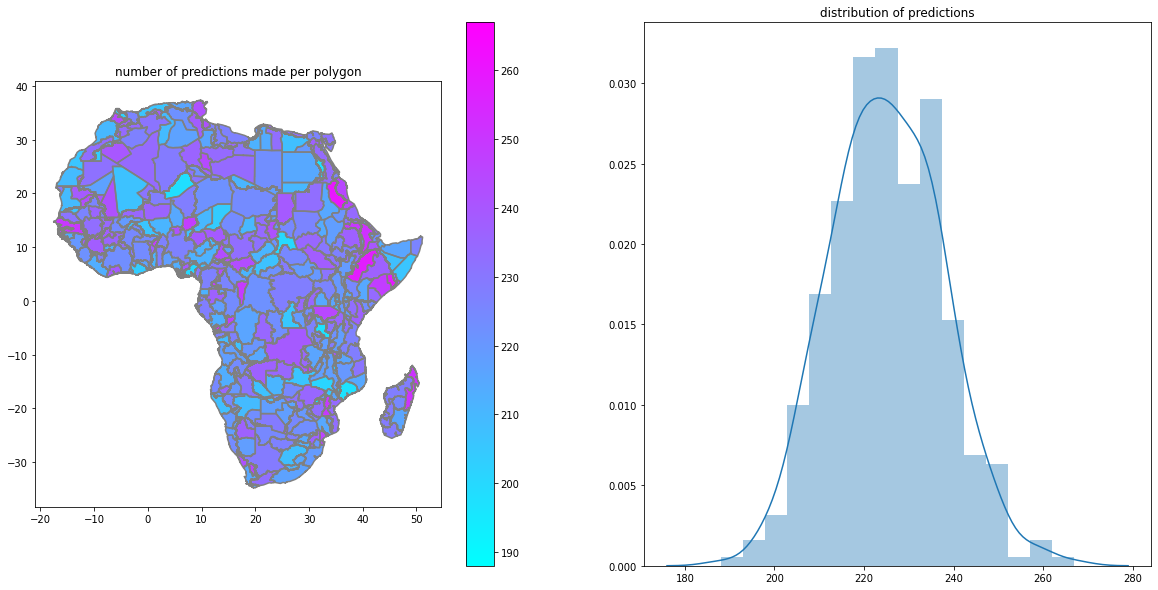

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions')
plt.savefig(os.path.join(out_dir, 'analyis_predictions.png'), dpi=300);

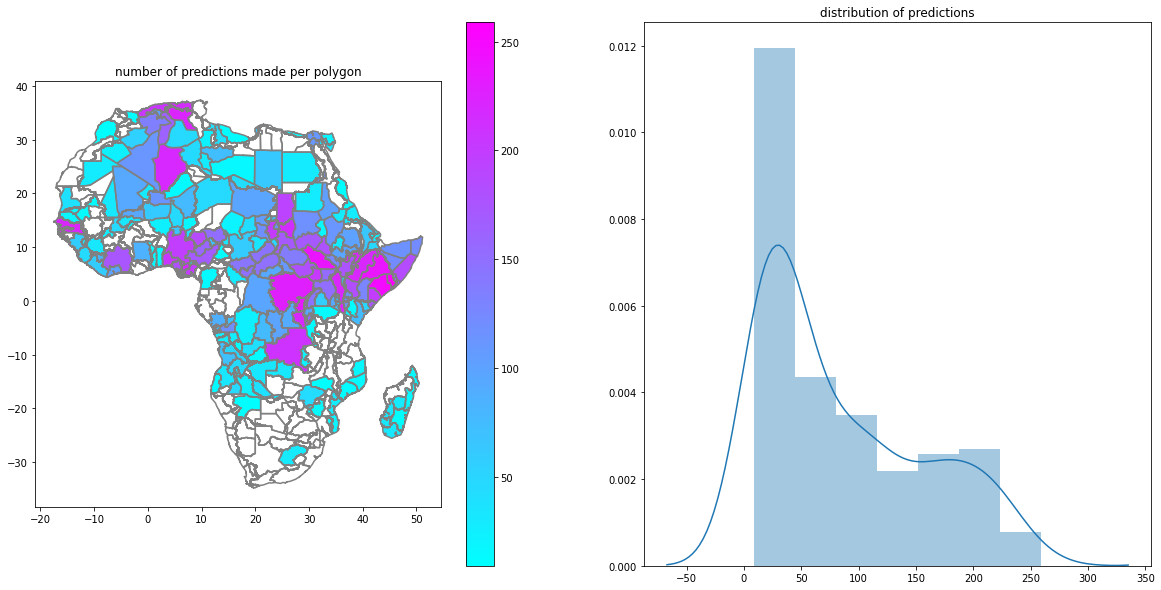

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit_1.plot(ax=ax1, column='ID_count', legend=True, cmap='cool')
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit_1.ID_count.values, ax=ax2)
ax2.set_title('distribution of predictions')
plt.savefig(os.path.join(out_dir, 'analyis_predictions_conflict_only.png'), dpi=300);

In [24]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(extent_active_polys_gdf)*100))

99.48 % of all active polygons are considered in test sample


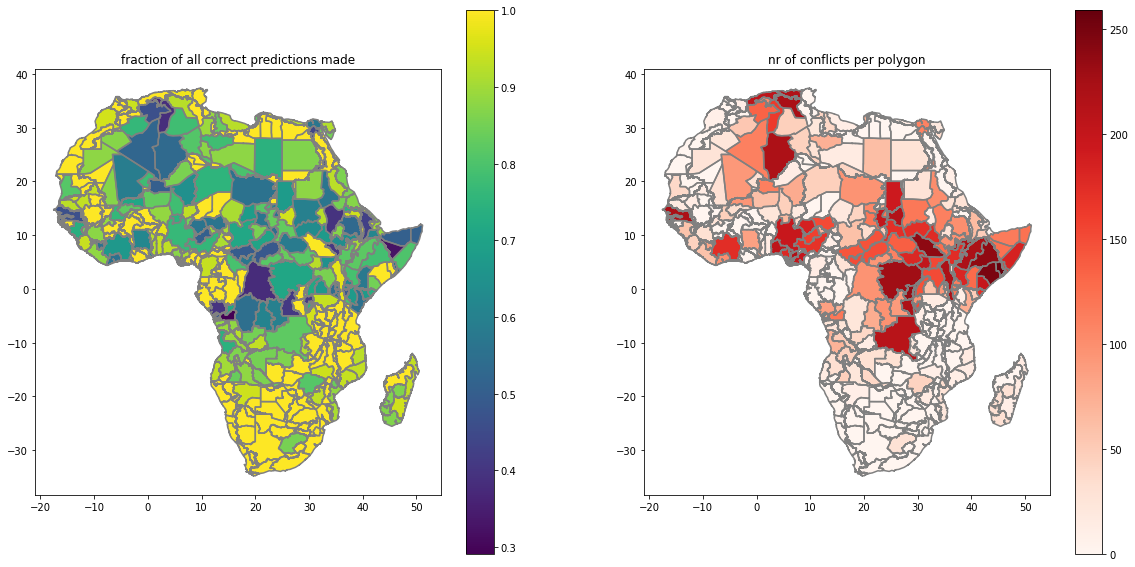

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='average_hit', legend=True, figsize=(20,10))
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('fraction of all correct predictions made')
gdf_hit.plot(ax=ax2, column='nr_of_test_confl', legend=True, cmap='Reds')
extent_active_polys_gdf.boundary.plot(ax=ax2, color='0.5')
ax2.set_title('nr of conflicts per polygon')
plt.savefig(os.path.join(out_dir, 'average_hit_precision.png'), dpi=300);

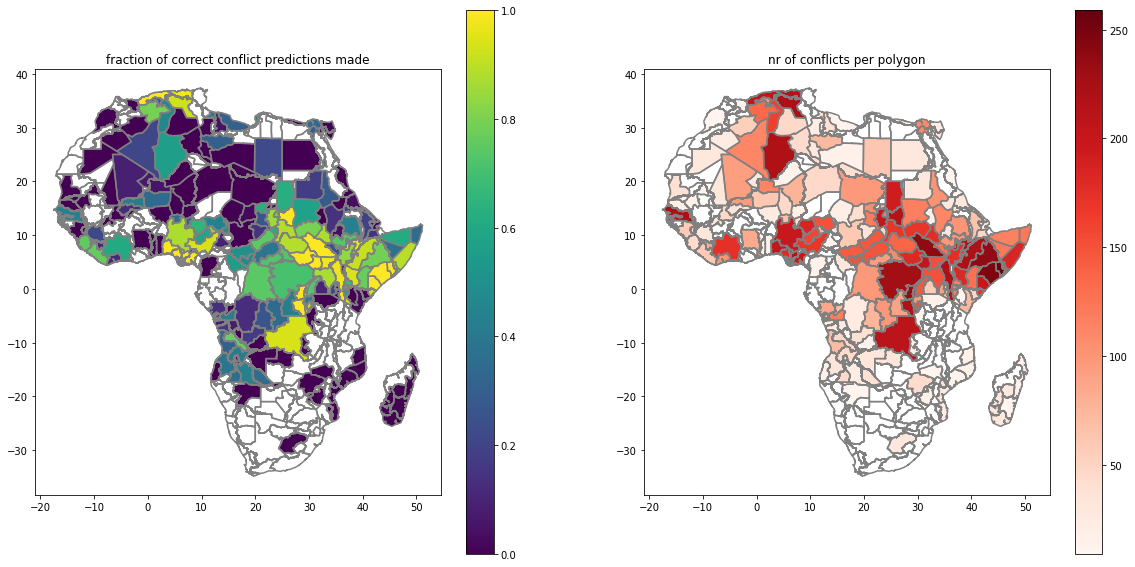

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit_1.plot(ax=ax1, column='average_hit', legend=True, figsize=(20,10))
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('fraction of correct conflict predictions made')
gdf_hit_1.plot(ax=ax2, column='nr_of_test_confl', legend=True, cmap='Reds')
extent_active_polys_gdf.boundary.plot(ax=ax2, color='0.5')
ax2.set_title('nr of conflicts per polygon')
plt.savefig(os.path.join(out_dir, 'average_hit_precision_conflicts_only.png'), dpi=300);